<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/01_kspace_tfms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kspace tfms

Implemented & tested with np and Pytorch tensors

## Setup

In [0]:
PROJ       = "fastmri"

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [4]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


## Data

### MRI data

In [0]:
import json

In [0]:
ds_name = "knee_singlecoil_val" # dataset name
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

In [7]:
path_json = PROJ_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
path_json

Path('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/fn2attr.json')

In [8]:
%time fn2attr = json.load(path_json)

CPU times: user 306 µs, sys: 878 µs, total: 1.18 ms
Wall time: 2.63 ms


In [0]:
fn2attr_items = L(i for i in fn2attr.items())

In [10]:
fn2attr_items

(#40) [('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000537.h5', {'n_slices': 35, 'kspace_shape': [3

### Imagenette data

In [0]:
path_net = untar_data(URLs.IMAGENETTE_160)
fnames_net = get_image_files(path_net)

In [12]:
fn_test = fnames_net[0]
fn_test

Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_7204.JPEG')

## Transforms (to/from kspace)

For real images, 
- FFT of a purely real array (eg image) has conjugate symmetry: ```
fft2_result[a, b] = fft2_result[-a, -b].conj()
```
- So rfft2 ouputs the left half (plus one column) of fft2 to save space & memory

Inverse rfft:
- RFFT output could correspond to either an odd or even length signal.
- By default, irfft assumes an even output length.
- To avoid losing information, the correct length of the real input must be given.

Sources: 

- https://stackoverflow.com/questions/43001729/how-should-i-interpret-the-output-of-numpy-fft-rfft2

- https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft.html

In [0]:
import scipy.fft as SP
import numpy.fft as NP

In [0]:
class NpTfms():

  # rfft w/ normalization
  rfft2  = partial(SP.rfft2,  norm="ortho")
  irfft2 = partial(SP.irfft2, norm="ortho")

  # fft w/ normalization - does not require complex input
  fft2  = partial(SP.fft2,  norm="ortho")
  ifft2 = partial(SP.ifft2, norm="ortho")


  # convert image to np array
  im2arr   = [np.array]

  # (uncentered) real arr obj to/from (centered) kspace
  real2k  = [rfft2, NP.fftshift]
  
  @classmethod
  def k2real(cls, s=None): return [NP.ifftshift, partial(cls.irfft2, s=s)]

  # same as above, but fft instead of rfft
  fft_real2k  = [fft2, NP.fftshift]
  fft_k2real  = [NP.ifftshift, ifft2]
  
  # (centered) complex arr obj to/from (centered) kspace
  complex2k  = [NP.ifftshift, fft2, NP.fftshift]
  k2complex  = [NP.ifftshift, ifft2, NP.fftshift]
   
  # Viz: kspace to amplitude-only img (log scale)
  np_abs = [np.abs]
  log_abs = [add(1e-9), np.log, np.abs]


In [0]:
class TensorTfms():

  # rfft in 2dim
  rfft2  = partial(torch.rfft,  signal_ndim = 2, normalized=True, onesided=True)
  irfft2 = partial(torch.irfft, signal_ndim = 2, normalized=True, onesided=True)

  # fft in 2dim - expects complex input
  fft2  = partial(torch.fft,  signal_ndim = 2, normalized=True)
  ifft2 = partial(torch.ifft, signal_ndim = 2, normalized=True)

  # convert image to Pytorch tensor
  def im2arr(im): return tensor(im).double()

  # convert real tensor into complex tensor
  def real2complex(t): return torch.stack((t, torch.zeros(t.shape).double()), axis=-1)

  # (uncentered) real arr obj to/from (centered) kspace
  real2k  = [rfft2, T.fftshift]

  @classmethod
  def k2real(cls, s=None): return [T.ifftshift, partial(cls.irfft2, signal_sizes=s)]

  # same as above, but fft instead of rfft
  fft_real2k  = [fft2, T.fftshift]
  fft_k2real  = [T.ifftshift, ifft2, T.complex_abs]
  
  # (centered) complex arr obj to/from (centered) kspace
  complex2k  = [T.fft2]
  k2complex  = [T.to_tensor, T.ifft2]
   
  # Viz: kspace to amplitude-only img (log scale)
  t_abs = [T.complex_abs]
  log_abs = [add(1e-9), np.log, np.abs]

In [0]:
def apply(data, tfms, pre=None, post=None): return Pipeline(L(pre) + L(tfms) + L(post))(data)

## Test transforms to/from kspace

In [0]:
# Viz, plot images function

def idx(lst,i, default=None): return lst[i] if i < len(lst) else default
def rep(o,n): return [o for _ in range(n)]

# useful fn to plot image fns in *args
def plot(imgs, titles=[None], cmaps=["gray"], nrows=1, ncols=1, figsize = (6,6), **kwargs):

   # listify so we input can be string instead of 1-item list
  imgs, titles, cmaps = L(imgs), L(titles), L(cmaps)

  # default set nrows, ncols = 1, len(imgs)
  if nrows * ncols != len(imgs): nrows, ncols = 1, len(imgs)

  # default repeat cmap until same size as images
  cmaps = cmaps * int(len(imgs)/len(cmaps))

  fig,axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
  axes = axes.flatten()
  for i,im in enumerate(imgs): 
    axes[i].imshow(im, cmap=idx(cmaps,i))
    axes[i].set_xticklabels([]), axes[i].set_yticklabels([])
    axes[i].set_title(idx(titles,i))
    axes[i].set_xlabel(im.shape)
  fig.show()

## Real images

In [0]:
img = PILImageBW.create(fn_test)

In [0]:
# numpy computation

arr = apply(img, NpTfms.im2arr) # numpy arr
orig_shape = arr.shape # to reconstruct using conjugate symmetry

# using rfft
k             = apply(arr, NpTfms.real2k)
rev_img       = apply(k, NpTfms.k2real(orig_shape))

# using fft
fft_k         = apply(arr, NpTfms.fft_real2k)
fft_rev_img   = apply(fft_k, NpTfms.fft_k2real)

# Viz kspace
k_abs         = apply(k, NpTfms.np_abs)
k_log_abs     = apply(k, NpTfms.log_abs)

In [0]:
np.testing.assert_array_almost_equal(img, rev_img)
np.testing.assert_array_almost_equal(img, fft_rev_img)

In [0]:
# Pytorch tensor computation

t_arr = apply(img, TensorTfms.im2arr) # float tensor
orig_shape = t_arr.shape

# using rfft
t_k             = apply(t_arr, TensorTfms.real2k)
t_rev_img       = apply(t_k, TensorTfms.k2real(orig_shape))

# using fft - requires complex arr
fft_arr         = apply(t_arr, TensorTfms.real2complex)
t_fft_k         = apply(fft_arr, TensorTfms.fft_real2k)
t_fft_rev_img   = apply(t_fft_k, TensorTfms.fft_k2real)

# Viz kspace
t_k_abs         = apply(t_k, TensorTfms.t_abs)
t_k_log_abs     = apply(t_k_abs, TensorTfms.log_abs)

In [0]:
np.testing.assert_array_almost_equal(fft_arr, T.to_tensor(arr + 0j))

In [0]:
np.testing.assert_array_almost_equal(t_arr, t_rev_img)
np.testing.assert_array_almost_equal(t_arr, t_fft_rev_img)

In [0]:
# complex tensor to complex np - by default real/imaginary axes are (0,1)
def t2np(a, axes=(0,1)): return np.asarray(a[...,axes[0]]) + 1j * np.asarray(a[...,axes[1]])

# random complex numpy array
def rand_complex_arr(n_rows, n_cols):
  return np.random.rand(n_rows, n_cols) + 1j *  np.random.rand(n_rows, n_cols)

# test T.to_tensor & t2np are inverses
id = Pipeline([T.to_tensor, t2np])

In [0]:
random_arr = rand_complex_arr(5,5)
np.testing.assert_array_almost_equal(random_arr,id(random_arr))

In [0]:
np.testing.assert_array_almost_equal(k_abs, t_k_abs)

In [0]:
np.testing.assert_array_almost_equal(k, t2np(t_k, axes=(1,0))) # for some reason complex tensor i & j out of order

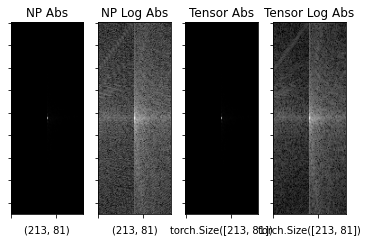

In [120]:
plot([k_abs, k_log_abs, t_k_abs, t_k_log_abs], ["NP Abs", "NP Log Abs", "Tensor Abs", "Tensor Log Abs"])

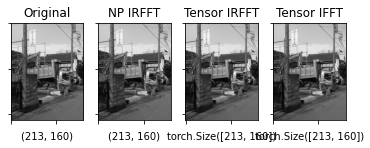

In [128]:
plot([img, rev_img, t_rev_img, t_fft_rev_img], ["Original", "NP IRFFT", "Tensor IRFFT", "Tensor IFFT"])

## MR images

In [0]:
# given fn2attr dict, indexes into array of kspace slices
class KSliceTfm(Transform):
  def __init__(self, fn2attr_items, is_valid=False):
    self.fn2attr_items, self.is_valid = fn2attr_items, is_valid
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.cumsum = np.cumsum(self.n_slices)
    self.total_n_slices = self.cumsum[-1]

  def encodes(self, i):
    fn2attr_idx  = np.searchsorted(self.cumsum, i)
    slice_idx = i - self.cumsum[fn2attr_idx]

    fname = self.fn2attr_items[fn2attr_idx][0]

    with h5py.File(fname, 'r') as data:
      kslice = data['kspace'][slice_idx]

    return kslice


In [0]:
kslices = KSliceTfm(fn2attr_items)

In [131]:
total_n_slices = kslices.total_n_slices
total_n_slices

1356

In [132]:
i = np.random.randint(0,total_n_slices)
i

604

In [133]:
ck = kslices(i)
ck.shape, type(ck)

((640, 372), numpy.ndarray)

In [0]:
k_abs     = apply(ck, NpTfms.np_abs)
k_log_abs = apply(ck, NpTfms.log_abs)

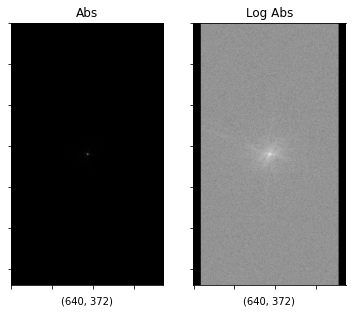

In [136]:
plot([k_abs, k_log_abs], ["Abs", "Log Abs"], ["gray", "gray_r"])

In [0]:
# numpy

complex_img  = apply(ck, NpTfms.k2complex)
img          = apply(complex_img, NpTfms.np_abs)

In [0]:
# pytorch

complex_img  = apply(ck, TensorTfms.k2complex)
t_img          = apply(complex_img, TensorTfms.t_abs)

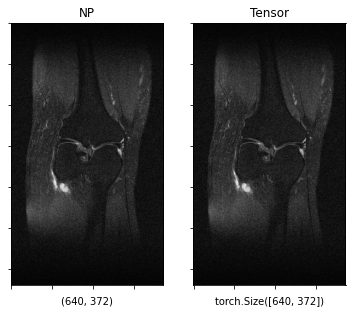

In [139]:
plot([img, t_img], ["NP", "Tensor"])

In [0]:
np.testing.assert_almost_equal(img, t_img, decimal=4) # max diff ~1e-4